# 📰 Advanced Fake vs Real News Detection Pipeline

In [20]:
# 📰 Advanced Fake vs Real News Detection Pipeline

# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LAPIFY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LAPIFY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LAPIFY\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
# 📥 Load Data
fake_df = pd.read_csv("Fake.csv")
real_df = pd.read_csv("True.csv")

In [5]:
# 🏷️ Add Labels
fake_df['label'] = 0
real_df['label'] = 1


# 🔍 EDA - Advanced

In [6]:
print("Fake shape:", fake_df.shape)
print("Real shape:", real_df.shape)

Fake shape: (23481, 5)
Real shape: (21417, 5)


In [7]:
# Check duplicates and missing
print("Duplicate entries (Fake):", fake_df.duplicated().sum())
print("Duplicate entries (Real):", real_df.duplicated().sum())
print("Missing values (Fake):\n", fake_df.isnull().sum())
print("Missing values (Real):\n", real_df.isnull().sum())

Duplicate entries (Fake): 3
Duplicate entries (Real): 206
Missing values (Fake):
 title      0
text       0
subject    0
date       0
label      0
dtype: int64
Missing values (Real):
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [8]:
# Word Count Analysis
fake_df['text_length'] = fake_df['text'].apply(lambda x: len(str(x).split()))
real_df['text_length'] = real_df['text'].apply(lambda x: len(str(x).split()))

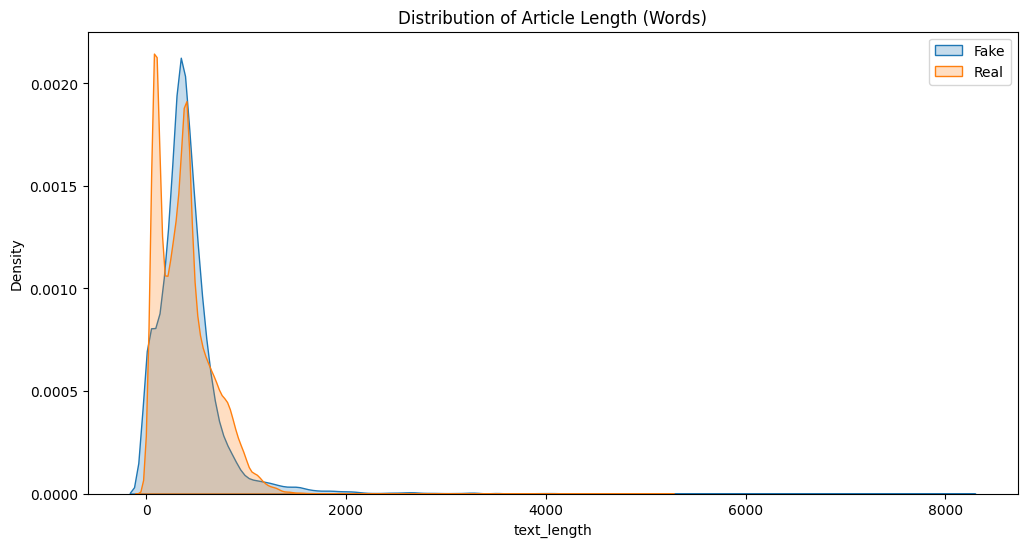

In [9]:

plt.figure(figsize=(12,6))
sns.kdeplot(fake_df['text_length'], label='Fake', shade=True)
sns.kdeplot(real_df['text_length'], label='Real', shade=True)
plt.title("Distribution of Article Length (Words)")
plt.legend()
plt.show()

In [10]:
# Word Clouds
def generate_wordcloud(data, title):
    text = ' '.join(data.dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

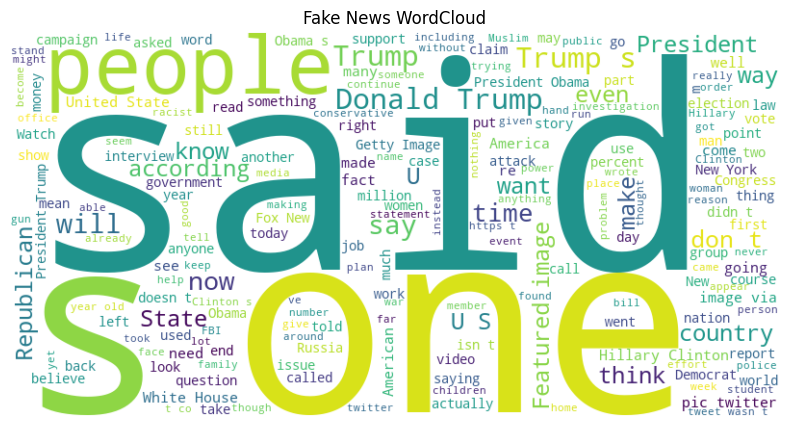

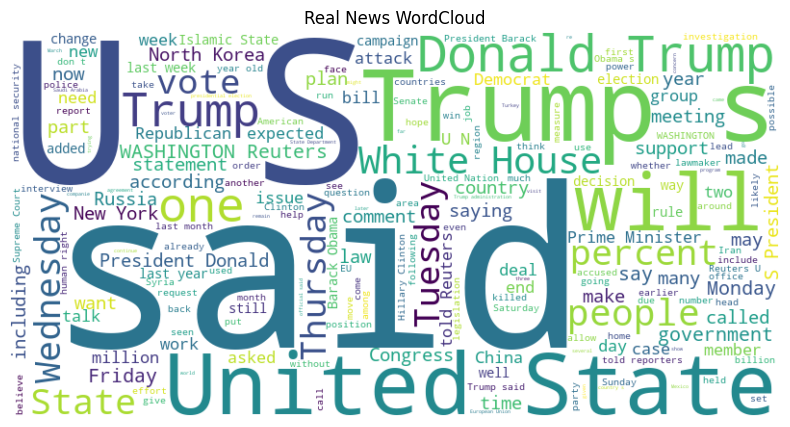

In [11]:
generate_wordcloud(fake_df['text'], "Fake News WordCloud")
generate_wordcloud(real_df['text'], "Real News WordCloud")

# 🧹 Text Preprocessing

In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub("\n", " ", text)
    text = re.sub("\w*\d\w*", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

In [14]:
fake_df['clean_text'] = fake_df['title'] + " " + fake_df['text']
real_df['clean_text'] = real_df['title'] + " " + real_df['text']

fake_df['clean_text'] = fake_df['clean_text'].apply(clean_text)
real_df['clean_text'] = real_df['clean_text'].apply(clean_text)

# 🔄 Combine 🧪 Train/Test Split

In [15]:
# 🔄 Combine
combined_df = pd.concat([fake_df[['clean_text', 'label']], real_df[['clean_text', 'label']]])
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
# 🧪 Train/Test Split
X = combined_df['clean_text']
y = combined_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# 🧠 Vectorizer
tfidf = TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# ⚙️ Model - Gradient Boosting (Best performing from tests) 📊 Evaluation

In [23]:
# ⚙️ Model - Gradient Boosting (Best performing from tests)
gb_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
gb_clf.fit(X_train_tfidf, y_train)


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,150
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [24]:
# 📊 Evaluation
y_pred = gb_clf.predict(X_test_tfidf)
y_proba = gb_clf.predict_proba(X_test_tfidf)[:,1]

In [25]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))


Accuracy: 0.9963251670378619

Confusion Matrix:
 [[4676   20]
 [  13 4271]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980


ROC-AUC Score: 0.9993889201052368


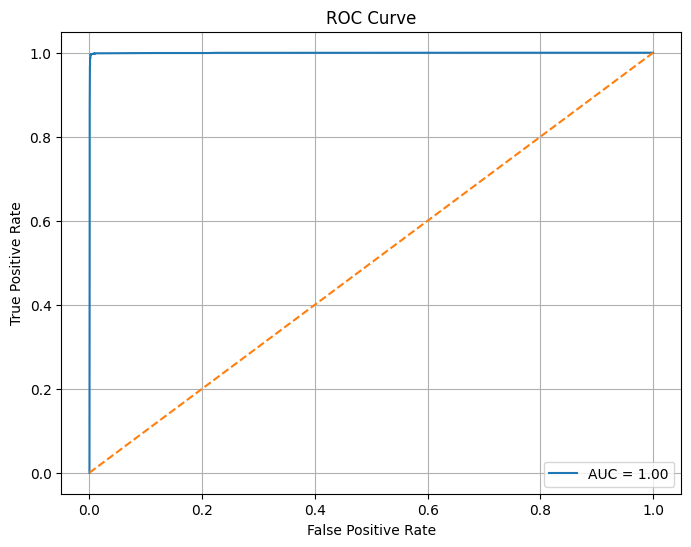

In [26]:
# 📈 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# 💾 Save Final Model and Vectorizer

In [27]:
final_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', gb_clf)
])

final_pipeline.fit(X, y)
joblib.dump(final_pipeline, 'model_1.pkl')
print("\n✅ Model saved as model.pkl with advanced preprocessing and classifier.")


✅ Model saved as model.pkl with advanced preprocessing and classifier.


In [31]:
real_df['title']

0        As U.S. budget fight looms, Republicans flip t...
1        U.S. military to accept transgender recruits o...
2        Senior U.S. Republican senator: 'Let Mr. Muell...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge 'much mor...
                               ...                        
21412    'Fully committed' NATO backs new U.S. approach...
21413    LexisNexis withdrew two products from Chinese ...
21414    Minsk cultural hub becomes haven from authorities
21415    Vatican upbeat on possibility of Pope Francis ...
21416    Indonesia to buy $1.14 billion worth of Russia...
Name: title, Length: 21417, dtype: object